In [2]:
import pandas as pd

import fsspec

fs = fsspec.filesystem(
    'filecache',
    target_protocol='s3',
    target_options={
        'key': 'YCAJEZ9PJ6itAHdK91ZPoWAp1',
        'secret': 'YCMesgjgH3dgexMVchUF5d9XRzBqYJGFllsUTP3v',
        'client_kwargs': {'endpoint_url': 'https://storage.yandexcloud.net'}
    },
    cache_storage='data',
    check_files=True)

In [4]:
with fs.open('s3://snap-simfin/us-shareprices-daily.zip') as f:
    prices = pd.read_csv(f, compression='zip', sep=';')

prices['Date'] = pd.to_datetime(prices.Date)

sp500tr = pd.read_csv('sp500tr.csv', sep=';', header=None, names=['date', 'value'])
sp500tr['date'] = pd.to_datetime(sp500tr.date, dayfirst=True)
sp500tr = sp500tr.set_index('date').sort_index()
sp500tr['scaling'] = sp500tr.value.pct_change() + 1
sp500tr['scaling_c'] = sp500tr.scaling.cumprod()

prices['index_scaling_c'] = prices.Date.map(sp500tr.scaling_c)
prices = prices.set_index(['Ticker', 'Date']).sort_index()

prices['price_scaling'] = prices.groupby('Ticker').Close.pct_change() + 1
prices['div_scaling'] = (prices.Dividend / prices.Close).fillna(0) + 1
prices['scaling'] = prices.price_scaling * prices.div_scaling
prices['scaling_c'] = prices.groupby('Ticker').scaling.cumprod()

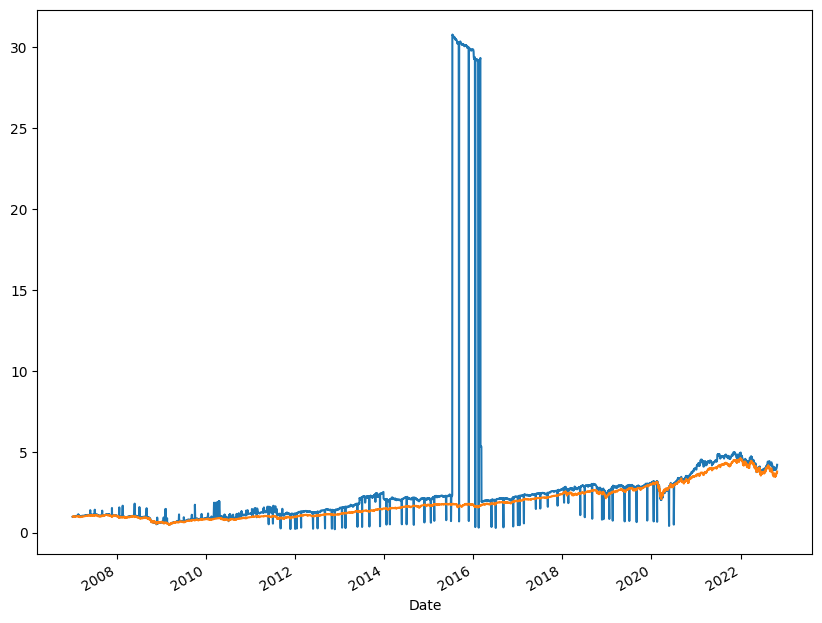

In [5]:
prices.groupby('Date').scaling_c.mean().plot(figsize=(10, 8));
prices.groupby('Date').index_scaling_c.mean().plot();

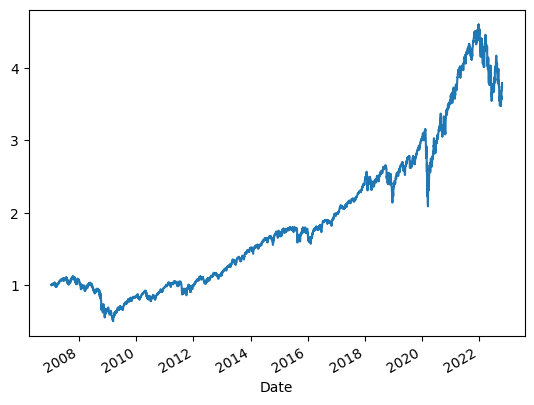

In [6]:
prices.groupby('Date').index_scaling_c.mean().plot();

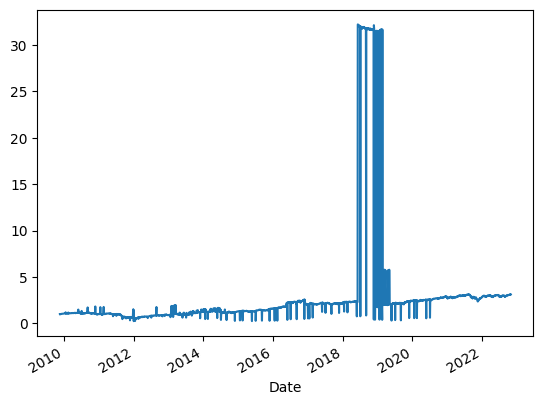

In [7]:
future = prices.groupby('Ticker').shift(365*2)
future.groupby('Date').scaling_c.mean().plot();

In [3]:
with fs.open('s3://snap-simfin/us-derived-shareprices-daily.zip') as f:
    dsp = pd.read_csv(f, compression='zip', sep=';')